In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
import cv2
import xraylib

from holotomo.holo import G
from holotomo.magnification import M
from holotomo.shift import S

%matplotlib inline

cp.cuda.Device(0).use()
np.random.seed(10)

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 1024  # object size in each dimension
ntheta = 1  # number of angles (rotations)

center = n/2  # rotation axis

# ID16a setup
ndist = 4

detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size

norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16
# sample size after demagnification
ne = int(np.ceil((n+2*pad)/norm_magnifications[-1]/8))*8  # make multiple of 8

## Read real and imaginary parts of the refractive index u = delta+i beta

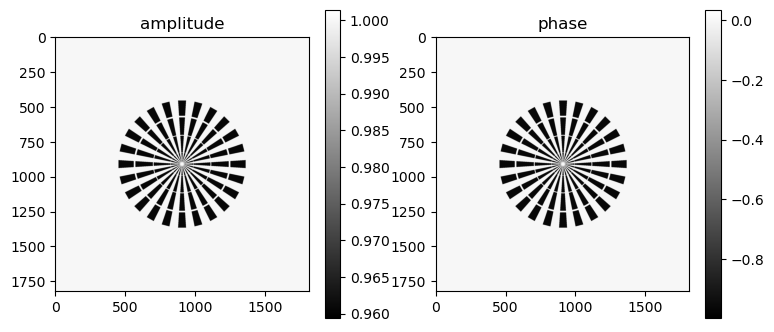

In [3]:
img = np.zeros((ne, ne, 3), np.uint8)
triangle = np.array([(ne//4, ne//2-ne//64), (ne//4, ne//2+ne//64), (ne//2-ne//128, ne//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((ne, ne, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-ne//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+ne//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-ne//2,ne//2),np.arange(-ne//2,ne//2))
x = x/ne*2
y = y/ne*2
# add holes in triangles
circ = (x**2+y**2>0.145)+(x**2+y**2<0.135)
circ *= (x**2+y**2>0.053)+(x**2+y**2<0.05)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
star = star*circ/255

v = np.arange(-ne//2,ne//2)/ne
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-5*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 2e-6/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength)[np.newaxis].astype('complex64')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

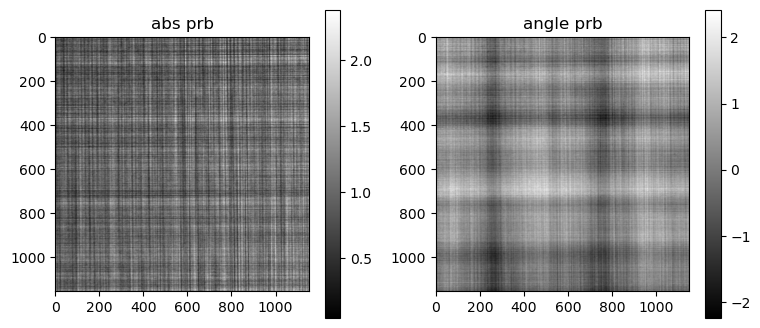

In [4]:
prb_abs = dxchange.read_tiff(f'../data/prb_id16a/prb_abs_{2048}.tiff')[0:1]
prb_phase = dxchange.read_tiff(f'../data/prb_id16a/prb_phase_{2048}.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')


prb = prb[:, 512-pad:-512+pad, 512-pad:-512+pad]
prb /= np.mean(np.abs(prb))
# prb[:]=1

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('abs prb')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('angle prb')
fig.colorbar(im)

### Smooth the probe, the loaded one is too noisy

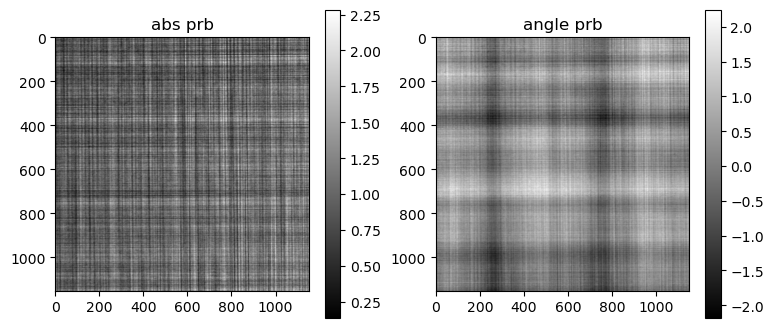

In [5]:
v = np.arange(-(n+2*pad)//2,(n+2*pad)//2)/(n+2*pad)
[vx,vy] = np.meshgrid(v,v)
v=np.exp(-5*(vx**2+vy**2))
prb = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(prb)))
prb = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(prb*v)))
prb = prb.astype('complex64')

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('abs prb')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('angle prb')
fig.colorbar(im)

# Shifts/drifts

In [6]:
# drift of the probe during collection of projections
shifts_ref = (np.random.random([ntheta, ndist, 2]).astype('float32')-0.5)*n/256  # typically small
# drift of the probe during collection of references
shifts_ref0 = (np.random.random([1, ndist, 2]).astype('float32')-0.5)*n/256

# use the first ref image as the global reference for illumination
shifts_ref0[0, 0, :] = 0

# shift of the sample when moving between differen planes
shifts_drift = np.zeros([ntheta, ndist, 2], dtype='float32')
# use the first plane as the global reference for illumination
shifts_drift[:, 1] = np.array([0.6, 0.3])
shifts_drift[:, 2] = np.array([-1.3, 1.5])
shifts_drift[:, 3] = np.array([2.3, -3.5])

np.save('data/shifts_drift', shifts_drift)
np.save('data/shifts_ref', shifts_ref)
np.save('data/shifts_ref0', shifts_ref0)

In [7]:
# set shifts for simulations
shifts = shifts_drift

### Compute holographic projections for all angles and all distances
#### $d=\left|\mathcal{G}_{z_j}((\mathcal{G}_{z'_j}q)(M_j \psi))\right|_2^2$, and reference data $d^r=\left|\mathcal{G}_{z'_j}q\right|$

In [8]:
from holotomo.chunking import gpu_batch

@gpu_batch
def fwd_holo(psi, shifts_ref, shifts, prb):
    # print(prb.shape)
    prb = cp.array(prb)
    
    data = cp.zeros([psi.shape[0],ndist,n,n],dtype='complex64')
    for i in range(ndist):        
        # ill shift for each acquisition
        prbr = cp.tile(prb,[psi.shape[0],1,1])
        
        prbr = S(prbr, shifts_ref[:,i])    
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])
        # object shift for each acquisition
        psir = S(psi, shifts[:,i]/norm_magnifications[i])      
        
        # scale object        
        if ne != n:
            psir = M(psir, norm_magnifications[i]*ne/(n+2*pad), n+2*pad)                
        
        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])   
        data[:,i] = psir[:,pad:n+pad,pad:n+pad]
    return data

@gpu_batch
def _fwd_holo0(prb, shifts_ref0):    
    data = cp.zeros([1,ndist, n, n], dtype='complex64')
    for j in range(ndist):
        # ill shift for each acquisition
        prbr = S(prb, shifts_ref0[:,j])                 
        # propagate illumination 
        data[:,j]=G(prbr, wavelength, voxelsize, distances[0])[:,pad:n+pad,pad:n+pad]        
    return data

def fwd_holo0(prb): 
    return _fwd_holo0(prb, shifts_ref0)

# print(prb.shape)
fpsi = fwd_holo(psi,shifts_ref,shifts,prb)
fref = fwd_holo0(prb)

### Take squared absolute value to simulate data on the detector and a reference image

In [9]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2

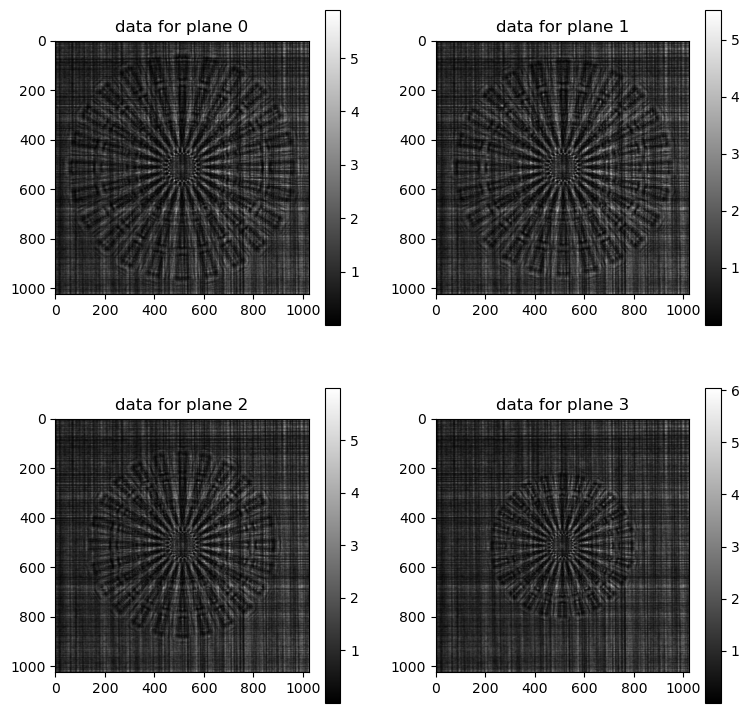

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[0,1],cmap='gray')
axs[0,1].set_title('data for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[0,2],cmap='gray')
axs[1,0].set_title('data for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[0,3],cmap='gray')
axs[1,1].set_title('data for plane 3')
fig.colorbar(im)

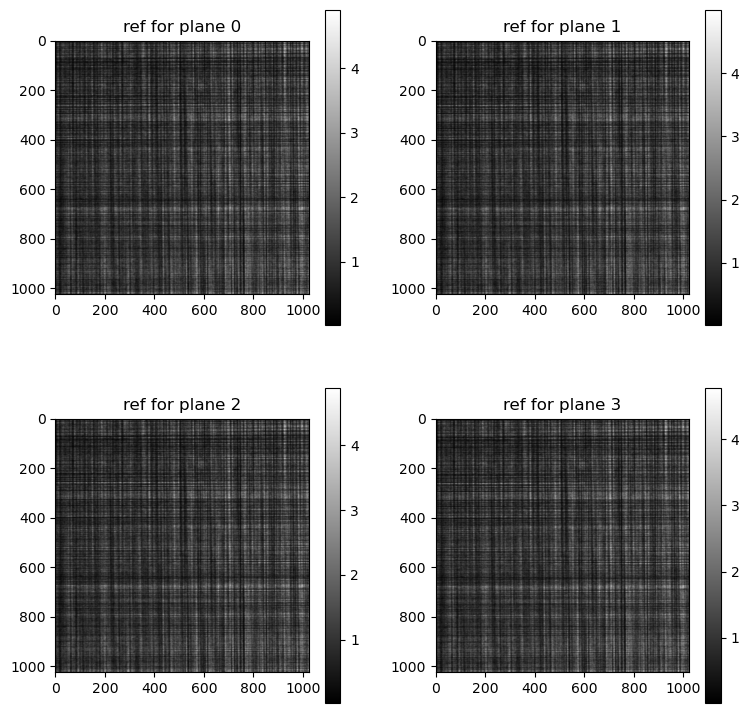

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(ref[0,0],cmap='gray')
axs[0,0].set_title('ref for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(ref[0,1],cmap='gray')
axs[0,1].set_title('ref for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(ref[0,2],cmap='gray')
axs[1,0].set_title('ref for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(ref[0,3],cmap='gray')
axs[1,1].set_title('ref for plane 3')
fig.colorbar(im)

# Save data, reference images, and shifts

In [12]:
for k in range(len(distances)):
    dxchange.write_tiff(data[:,k],f'data/data_{n}_{k}',overwrite=True)
for k in range(len(distances)):
    dxchange.write_tiff(ref[:,k],f'data/ref_{n}_{k}',overwrite=True)